In [ ]:
!pip install --upgrade --quiet "natural-pdf[ai] @ git+https://github.com/jsoma/natural-pdf.git"

# Multi-page flows

*Sometimes* you have data that flows over multiple columns, or pages, or just... isn't arranged in a "normal" top-to-bottom way.

CropBox missing from /Page, defaulting to MediaBox


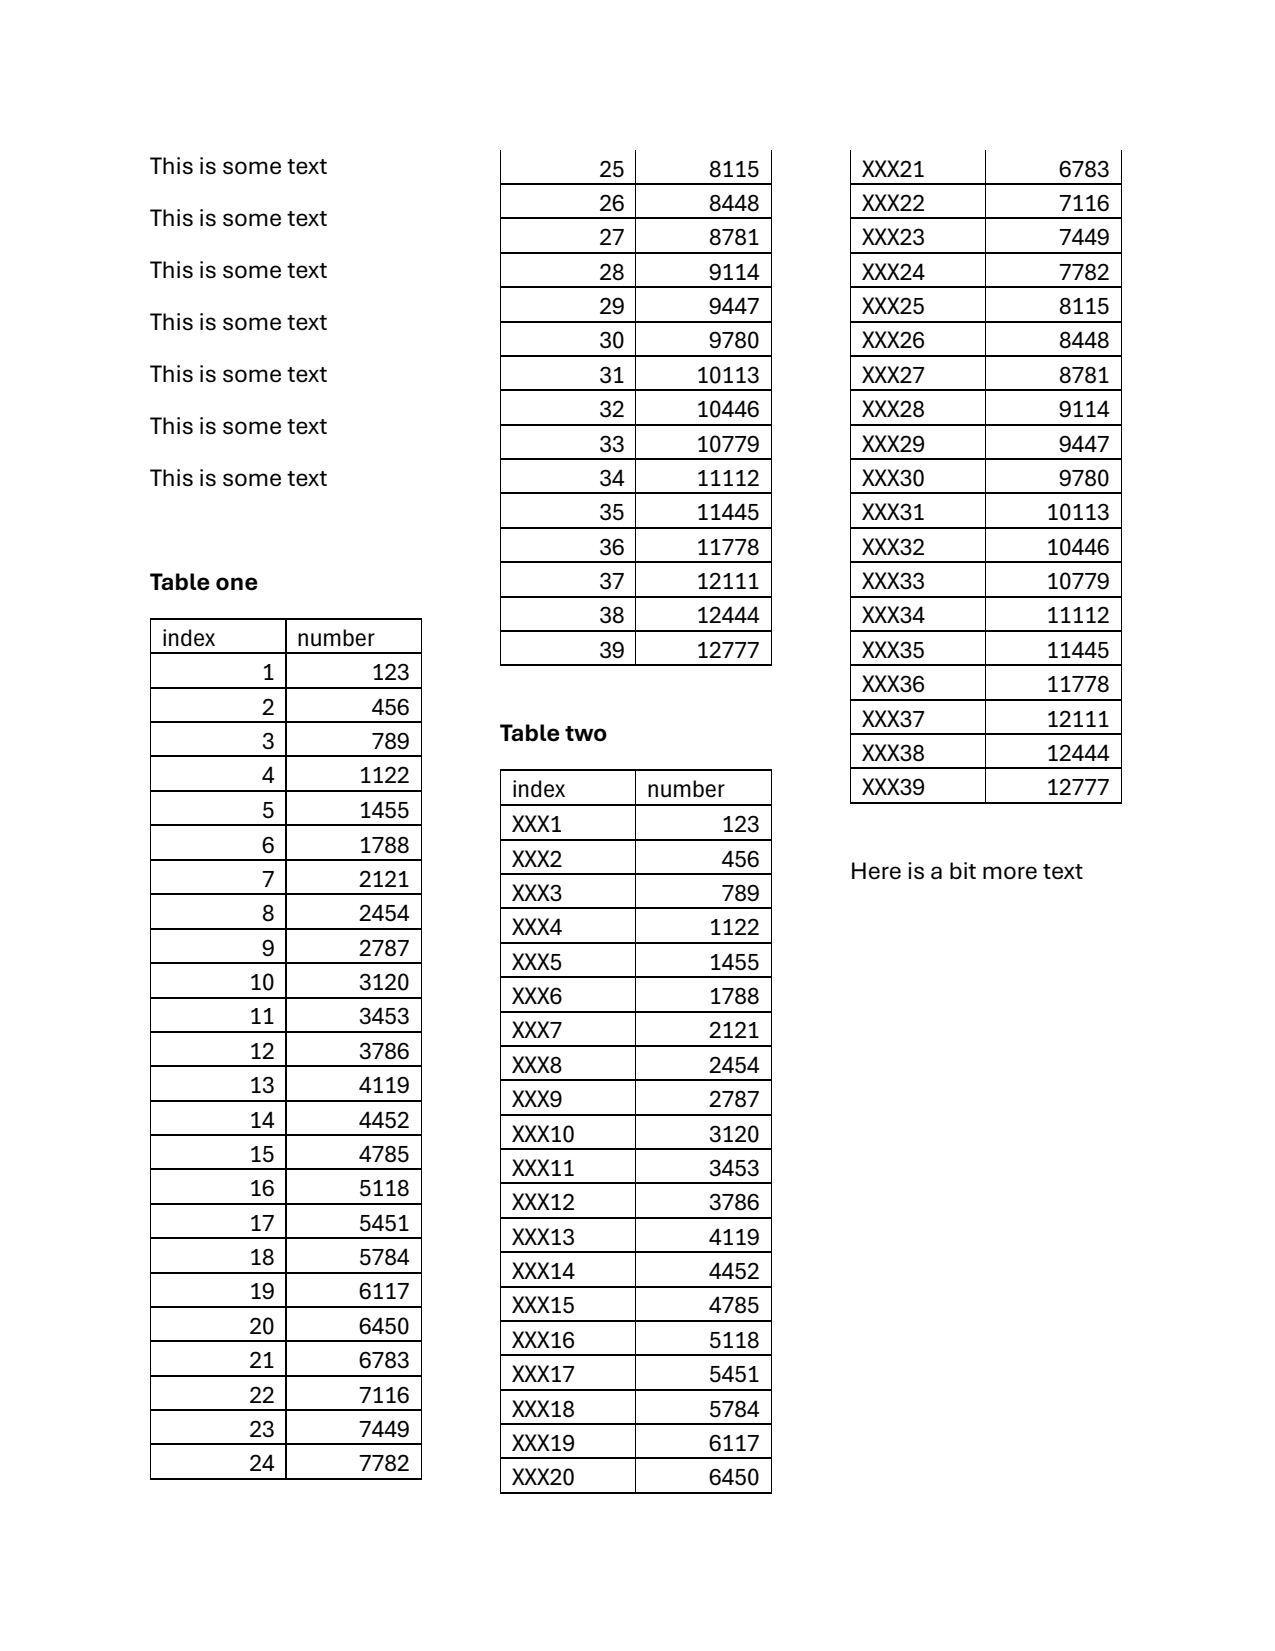

In [1]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/abraji25-pdfs/raw/refs/heads/main/multicolumn.pdf")
page = pdf.pages[0]
page.show()

Natural PDF deals with these through [reflowing pages](https://jsoma.github.io/natural-pdf/reflowing-pages/), where you grab specific regions of a page and then paste them back together either vertically or horizontally.

In this example we're splitting the page into three columns.

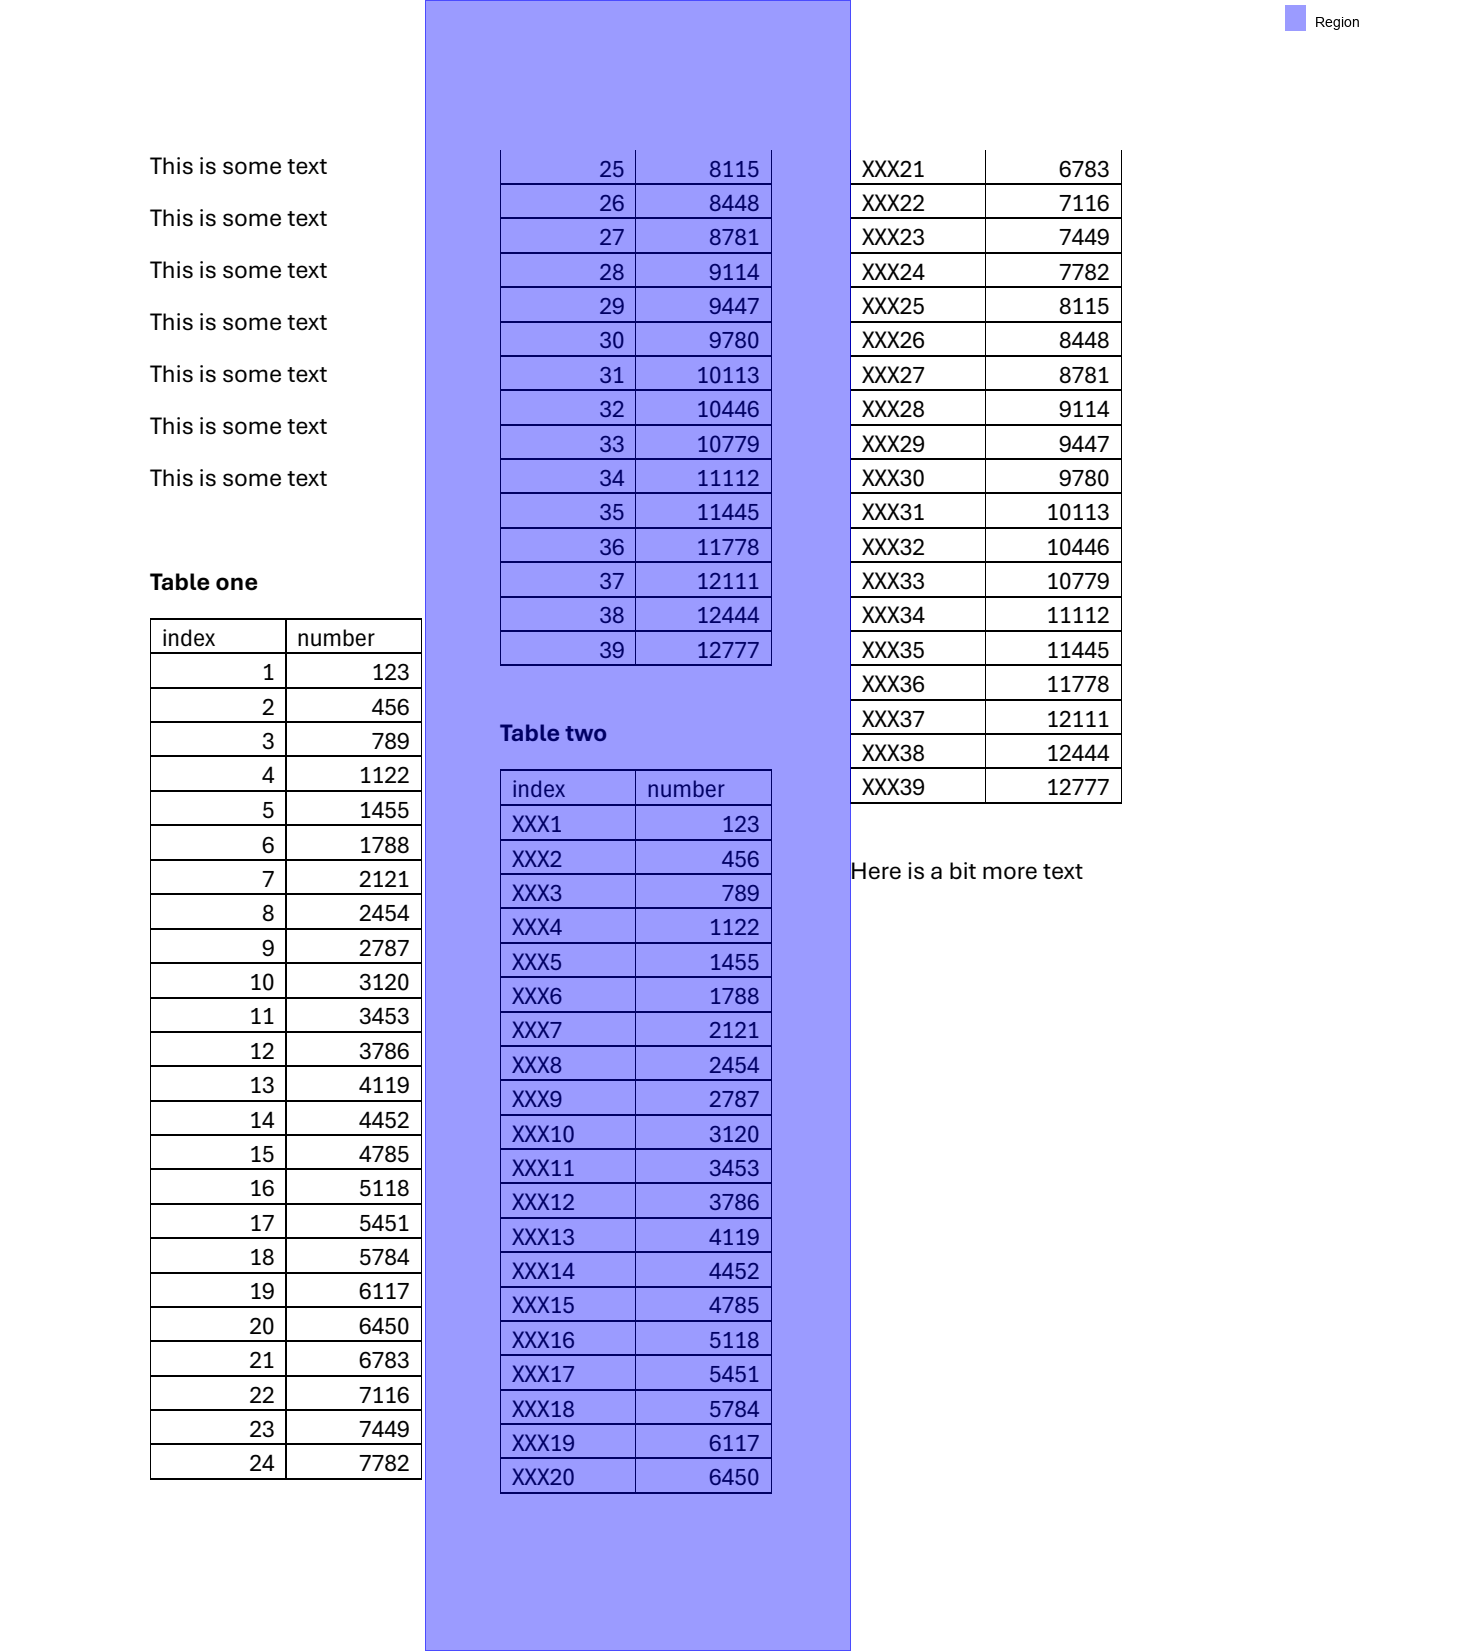

In [ ]:
left = page.region(left=0, right=page.width/3, top=0, bottom=page.height)
mid = page.region(left=page.width/3, right=page.width/3*2, top=0, bottom=page.height)
right = page.region(left=page.width/3*2, right=page.width, top=0, bottom=page.height)
page.highlight(left, mid, right)

Now let's **stack them on top of each other**.

In [3]:
from natural_pdf.flows import Flow

stacked = [left, mid, right]
flow = Flow(segments=stacked, arrangement="vertical")

Now any time we want to use spatial comparisons, like "find something below this," it *just works*.

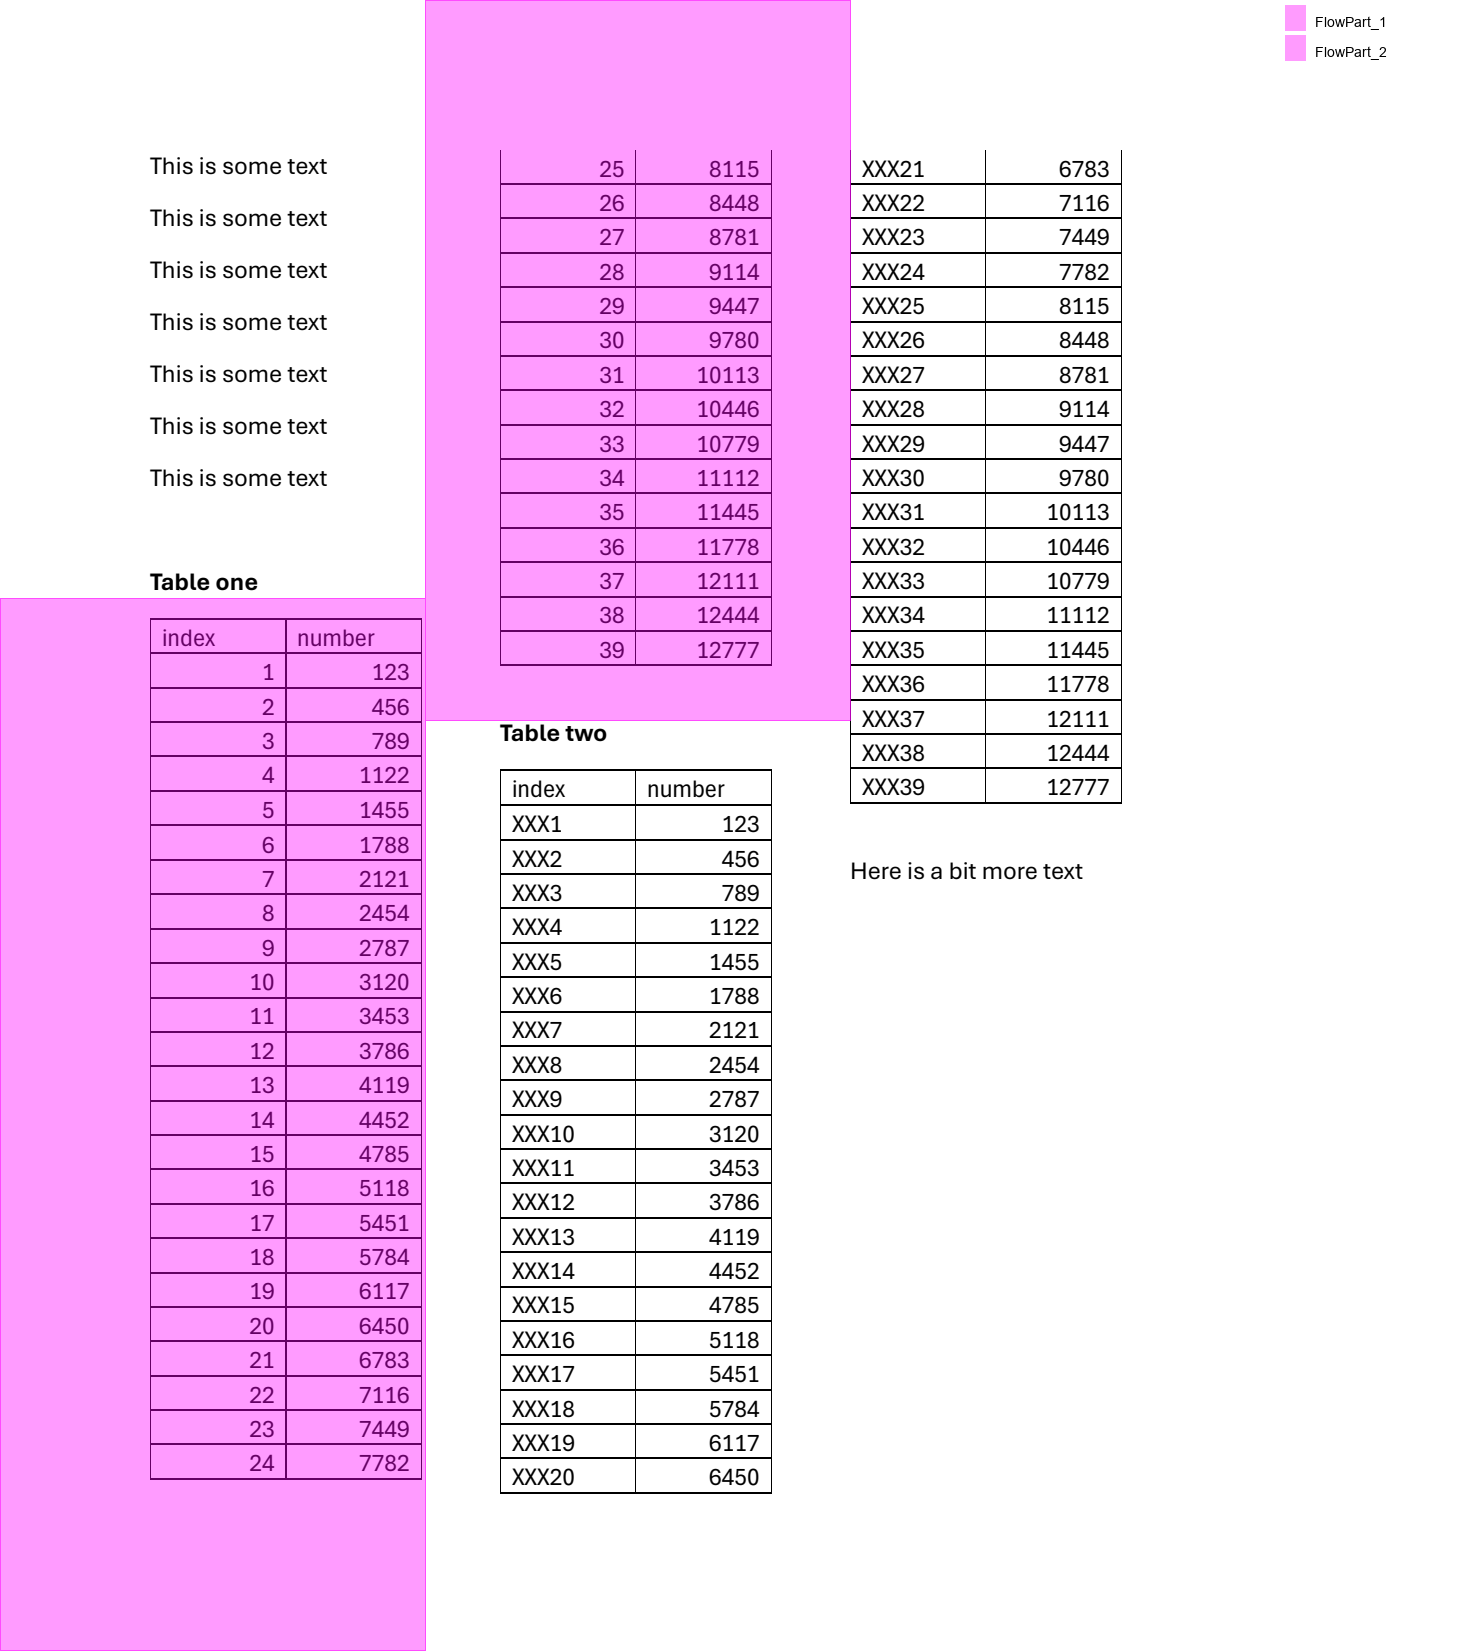

In [4]:
region = (
    flow
    .find('text:contains("Table one")')
    .below(
        until='text:contains("Table two")',
        include_endpoint=False
    )
)
region.show()

It works for text, it works for tables, it works for **anything**. Let's see how we can get both tables on the page.

First we find the bold headers – we need to say `width > 10` because otherwise it pulls some weird tiny empty boxes.

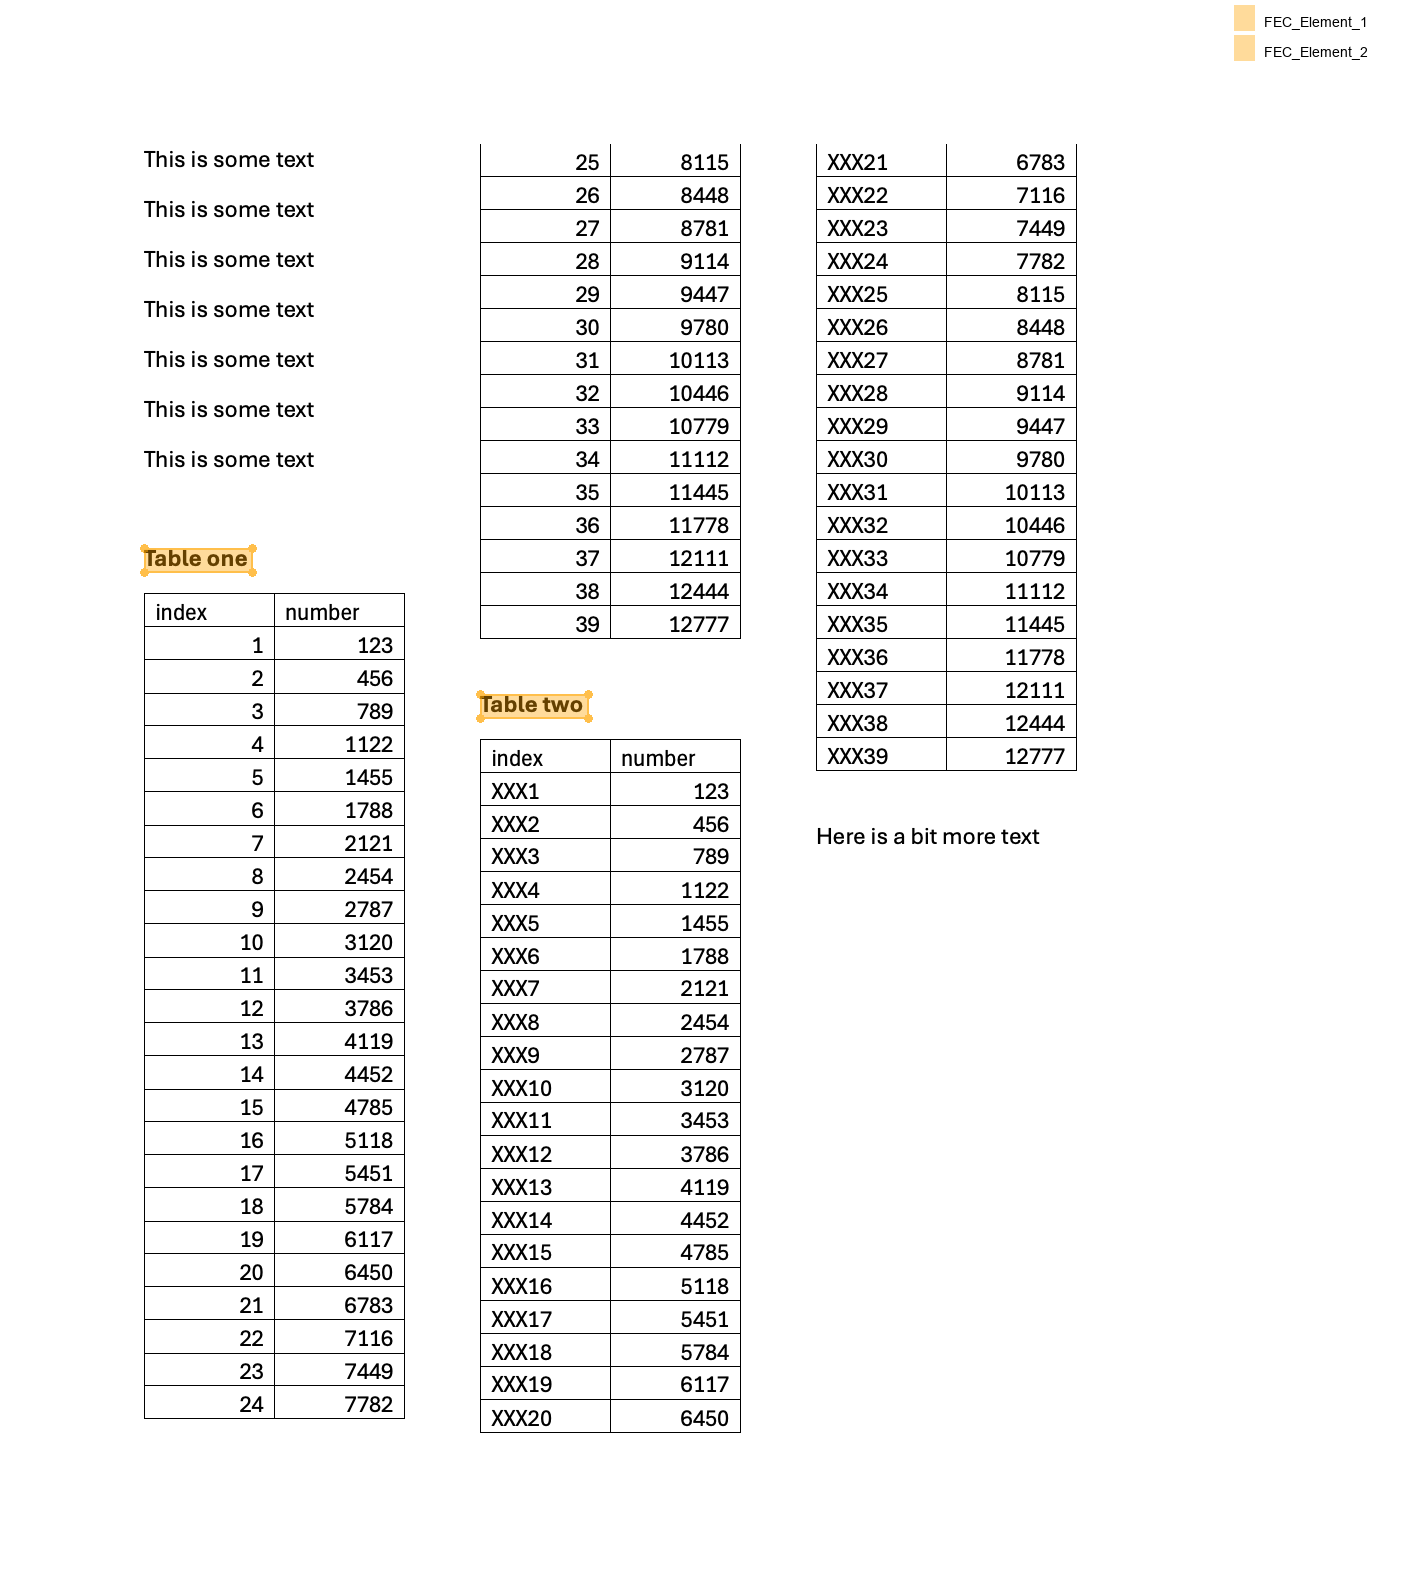

In [5]:
(
    flow
    .find_all('text[width>10]:bold')
    .show()
)

Then we take each of those headers, and go down down down until we either hit another bold header *or* the "Here is a bit more text" text. 

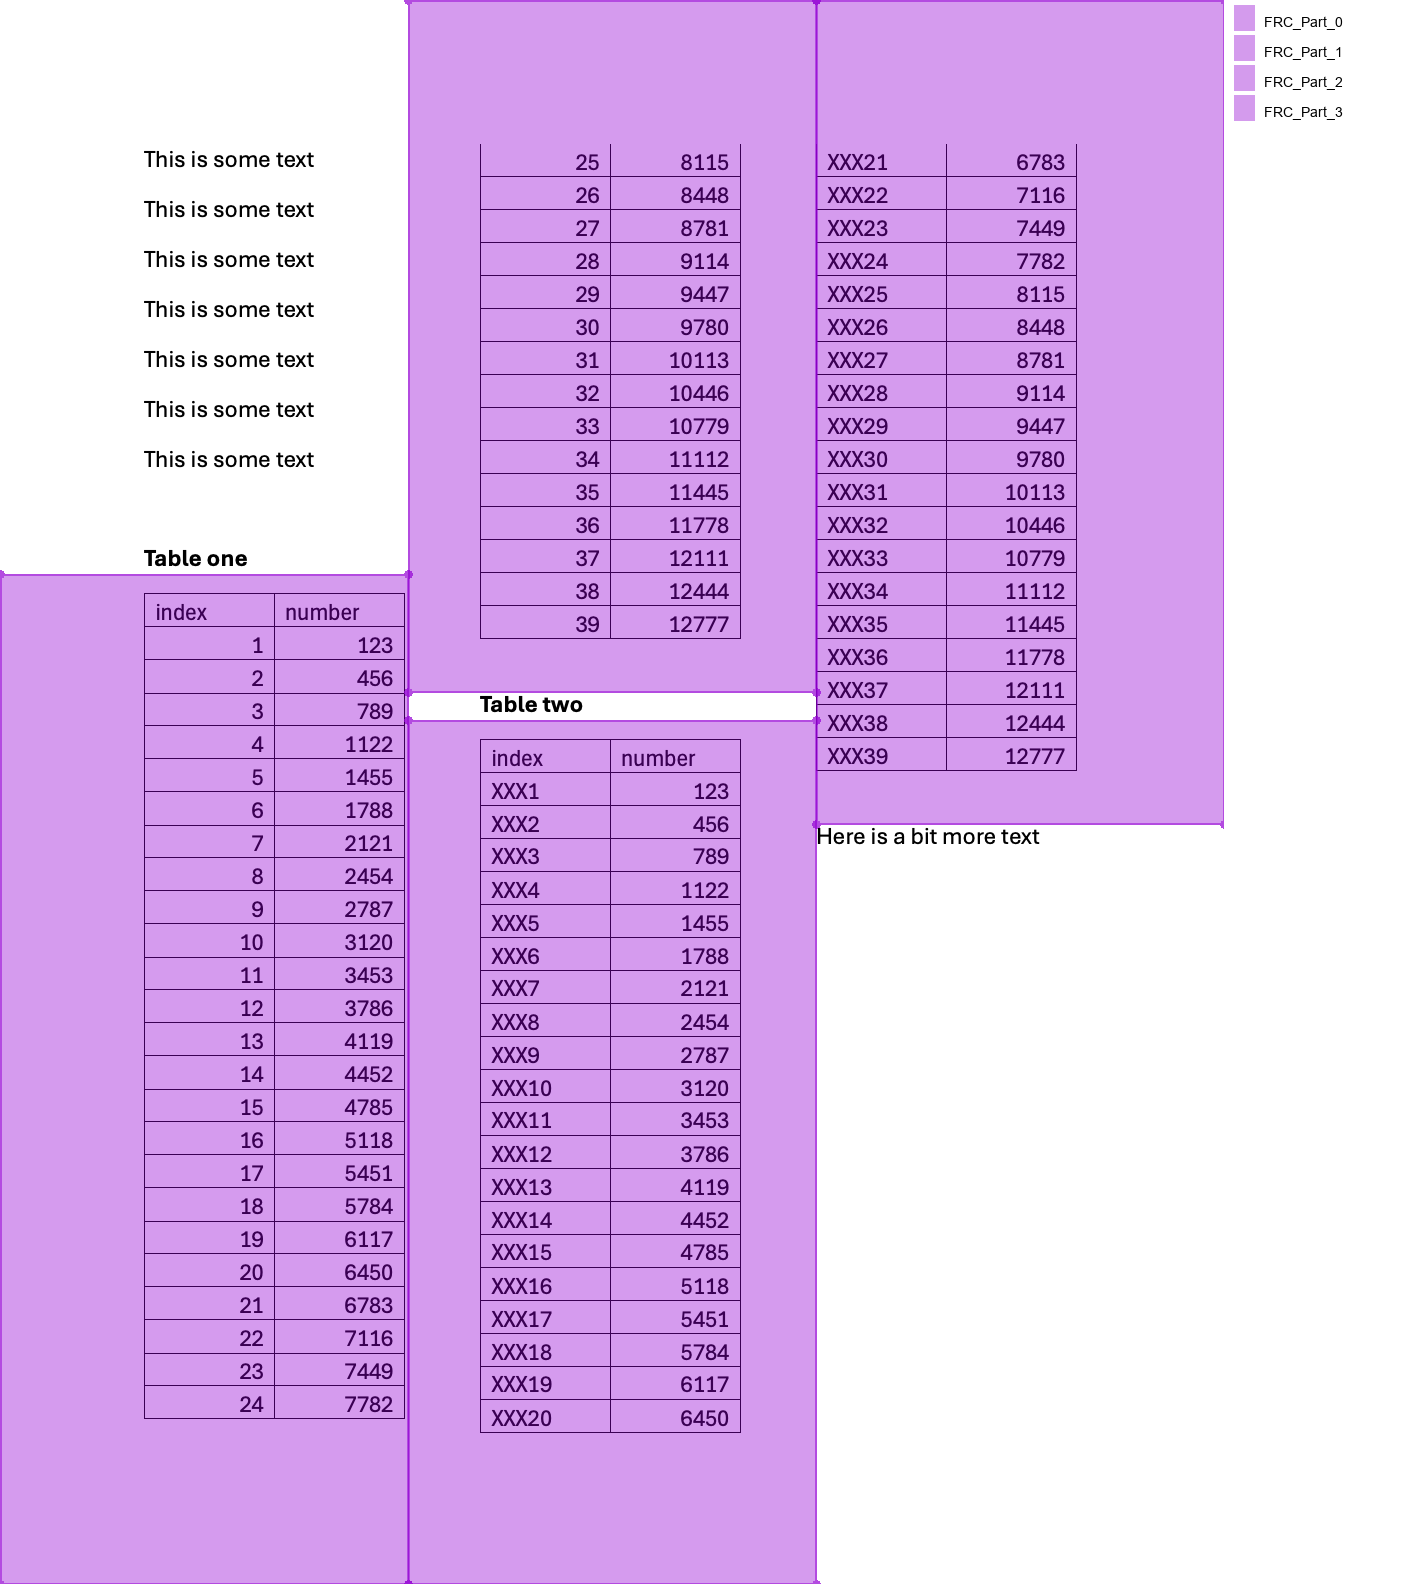

In [6]:
regions = (
    flow
    .find_all('text[width>10]:bold')
    .below(
        until='text[width>10]:bold|text:contains("Here is a bit")',
        include_endpoint=False
    )
)
regions.show()


Now we can use `.extract_table()` on *each individual region* to give us a bunch of tables.

In [7]:
tables = regions.apply(lambda col: col.extract_table())

second_table = tables[1]

columns = second_table[0]
rows = second_table[1:]

import pandas as pd

df = pd.DataFrame(rows, columns=columns)
df

index number
0    XXX1    123
1    XXX2    456
2    XXX3    789
3    XXX4   1122
4    XXX5   1455
5    XXX6   1788
6    XXX7   2121
7    XXX8   2454
8    XXX9   2787
9   XXX10   3120
10  XXX11   3453
11  XXX12   3786
12  XXX13   4119
13  XXX14   4452
14  XXX15   4785
15  XXX16   5118
16  XXX17   5451
17  XXX18   5784
18  XXX19   6117
19  XXX20   6450
20  XXX22   7116
21  XXX23   7449
22  XXX24   7782
23  XXX25   8115
24  XXX26   8448
25  XXX27   8781
26  XXX28   9114
27  XXX29   9447
28  XXX30   9780
29  XXX31  10113
30  XXX32  10446
31  XXX33  10779
32  XXX34  11112
33  XXX35  11445
34  XXX36  11778
35  XXX37  12111
36  XXX38  12444
37  XXX39  12777

# Layout analysis and magic table extraction

Similar to how we have feelings about what things are on a page - headers, tables, graphics – computers also have opinions! Just like some AI models have been trained to do things like identify pictures of cats and dogs or spell check, others are capable of **layout analysis** - [YOLO](https://huggingface.co/spaces/omoured/YOLOv11-Document-Layout-Analysis), [surya](https://github.com/datalab-to/surya), etc etc etc. There are a million! [TATR](https://github.com/microsoft/table-transformer) is one of the useful ones for us, it's *just for table detection*.

But honestly: they're mostly trained on academic papers, so they aren't very good at the kinds of awful documents that journalists have to deal with. And with Natural PDF, you're probably selecting `text[size>12]:bold` in order to find headlines, anyway. *But* if your page has no readable text, they might be able to provide some useful information.

Let's start with [YOLO](https://github.com/opendatalab/DocLayout-YOLO), the default.

In [8]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/abraji25-pdfs/raw/refs/heads/main/needs-ocr.pdf")
page = pdf.pages[0]

CropBox missing from /Page, defaulting to MediaBox



image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpcxydtq9a/temp_layout_image.png: 1024x800 2 titles, 3 plain texts, 2 abandons, 1 table, 693.8ms
Speed: 5.1ms preprocess, 693.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 800)


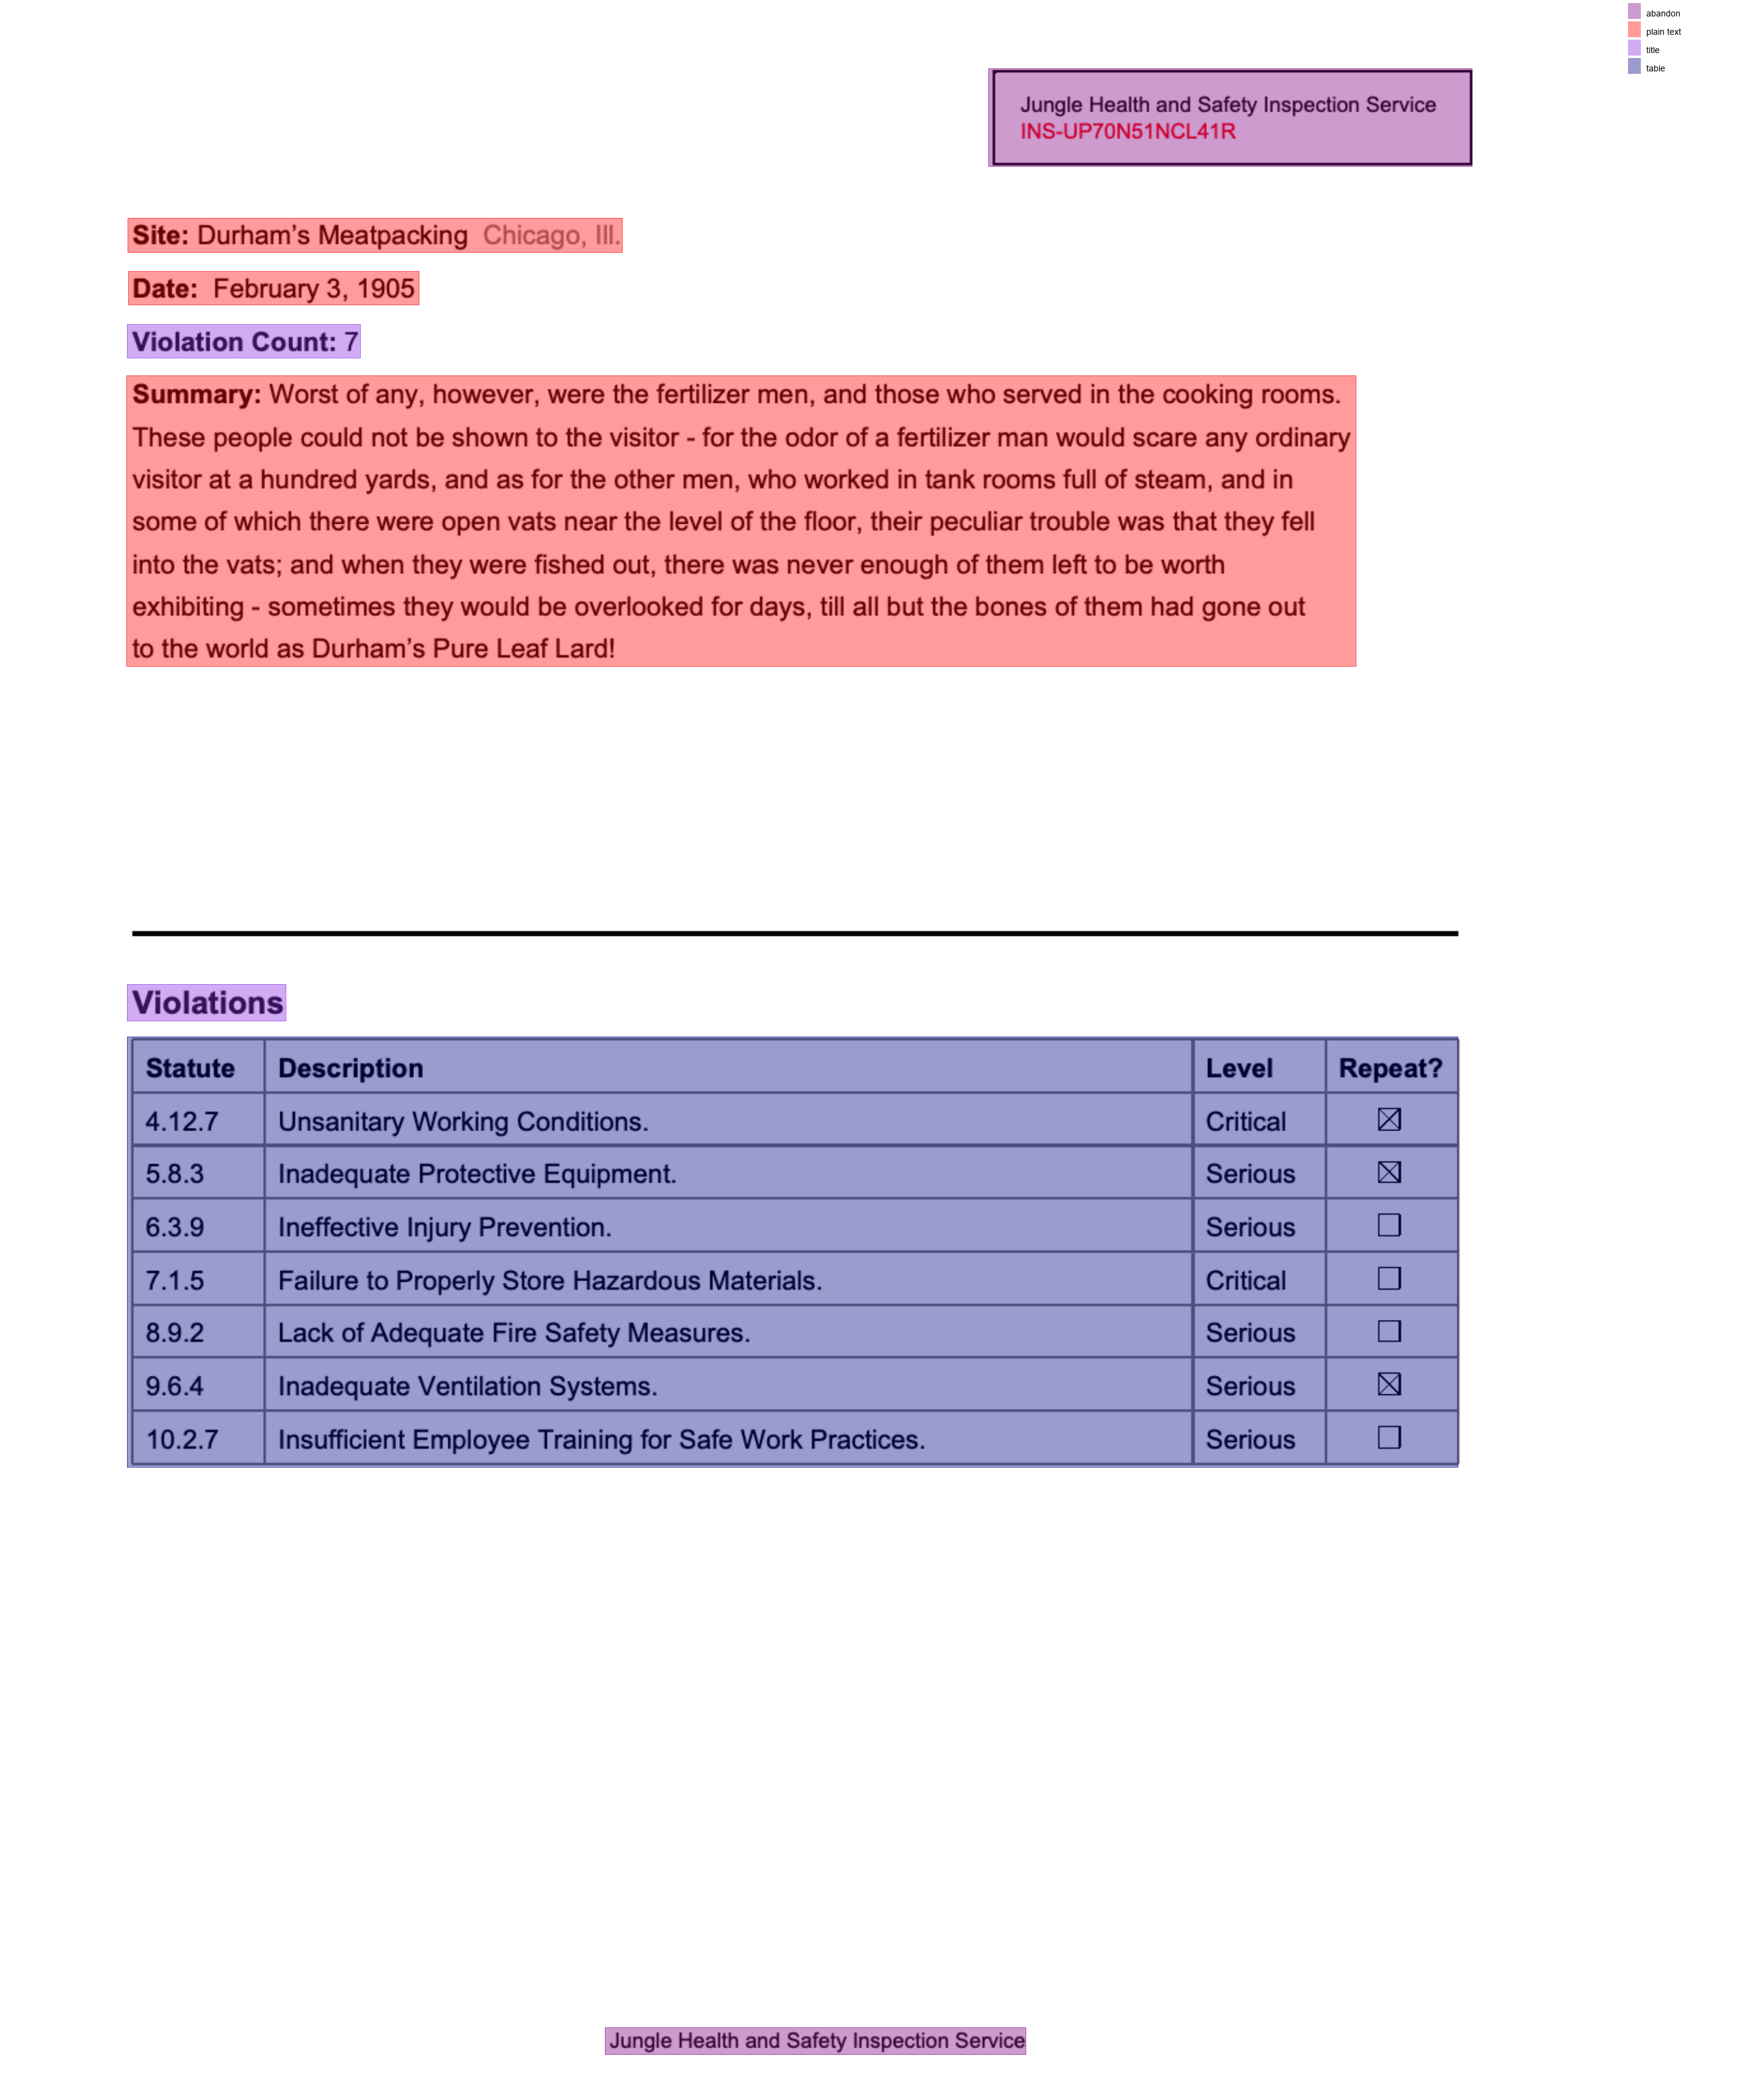

In [9]:
# default is YOLO
page.analyze_layout()
page.find_all('region').show(group_by='type')

In [10]:
page.find('table').apply_ocr()
text = page.extract_text()
print(text)

Using CPU. Note: This module is much faster with a GPU.
/Users/soma/Development/natural-pdf/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Statute Description Level Repeat?
4.12.7 Unsanitary Working Conditions. Critical
5.8.3 Inadequate Protective Equipment: Serious
6.3.9 Ineffective Injury Prevention  Serious
7.1.5 Failure to Properly Store Hazardous Materials Critical
8.9.2 Lack of Adequate Fire Safety Measures. Serious
9.6.4 Inadequate Ventilation Systems. Serious
10.2.7 Insufficient Employee Training for Safe Work Practices_ Serious


### Better layout analysis with tables

Let's see what **TATR** - Microsoft's table transformer – finds for us.

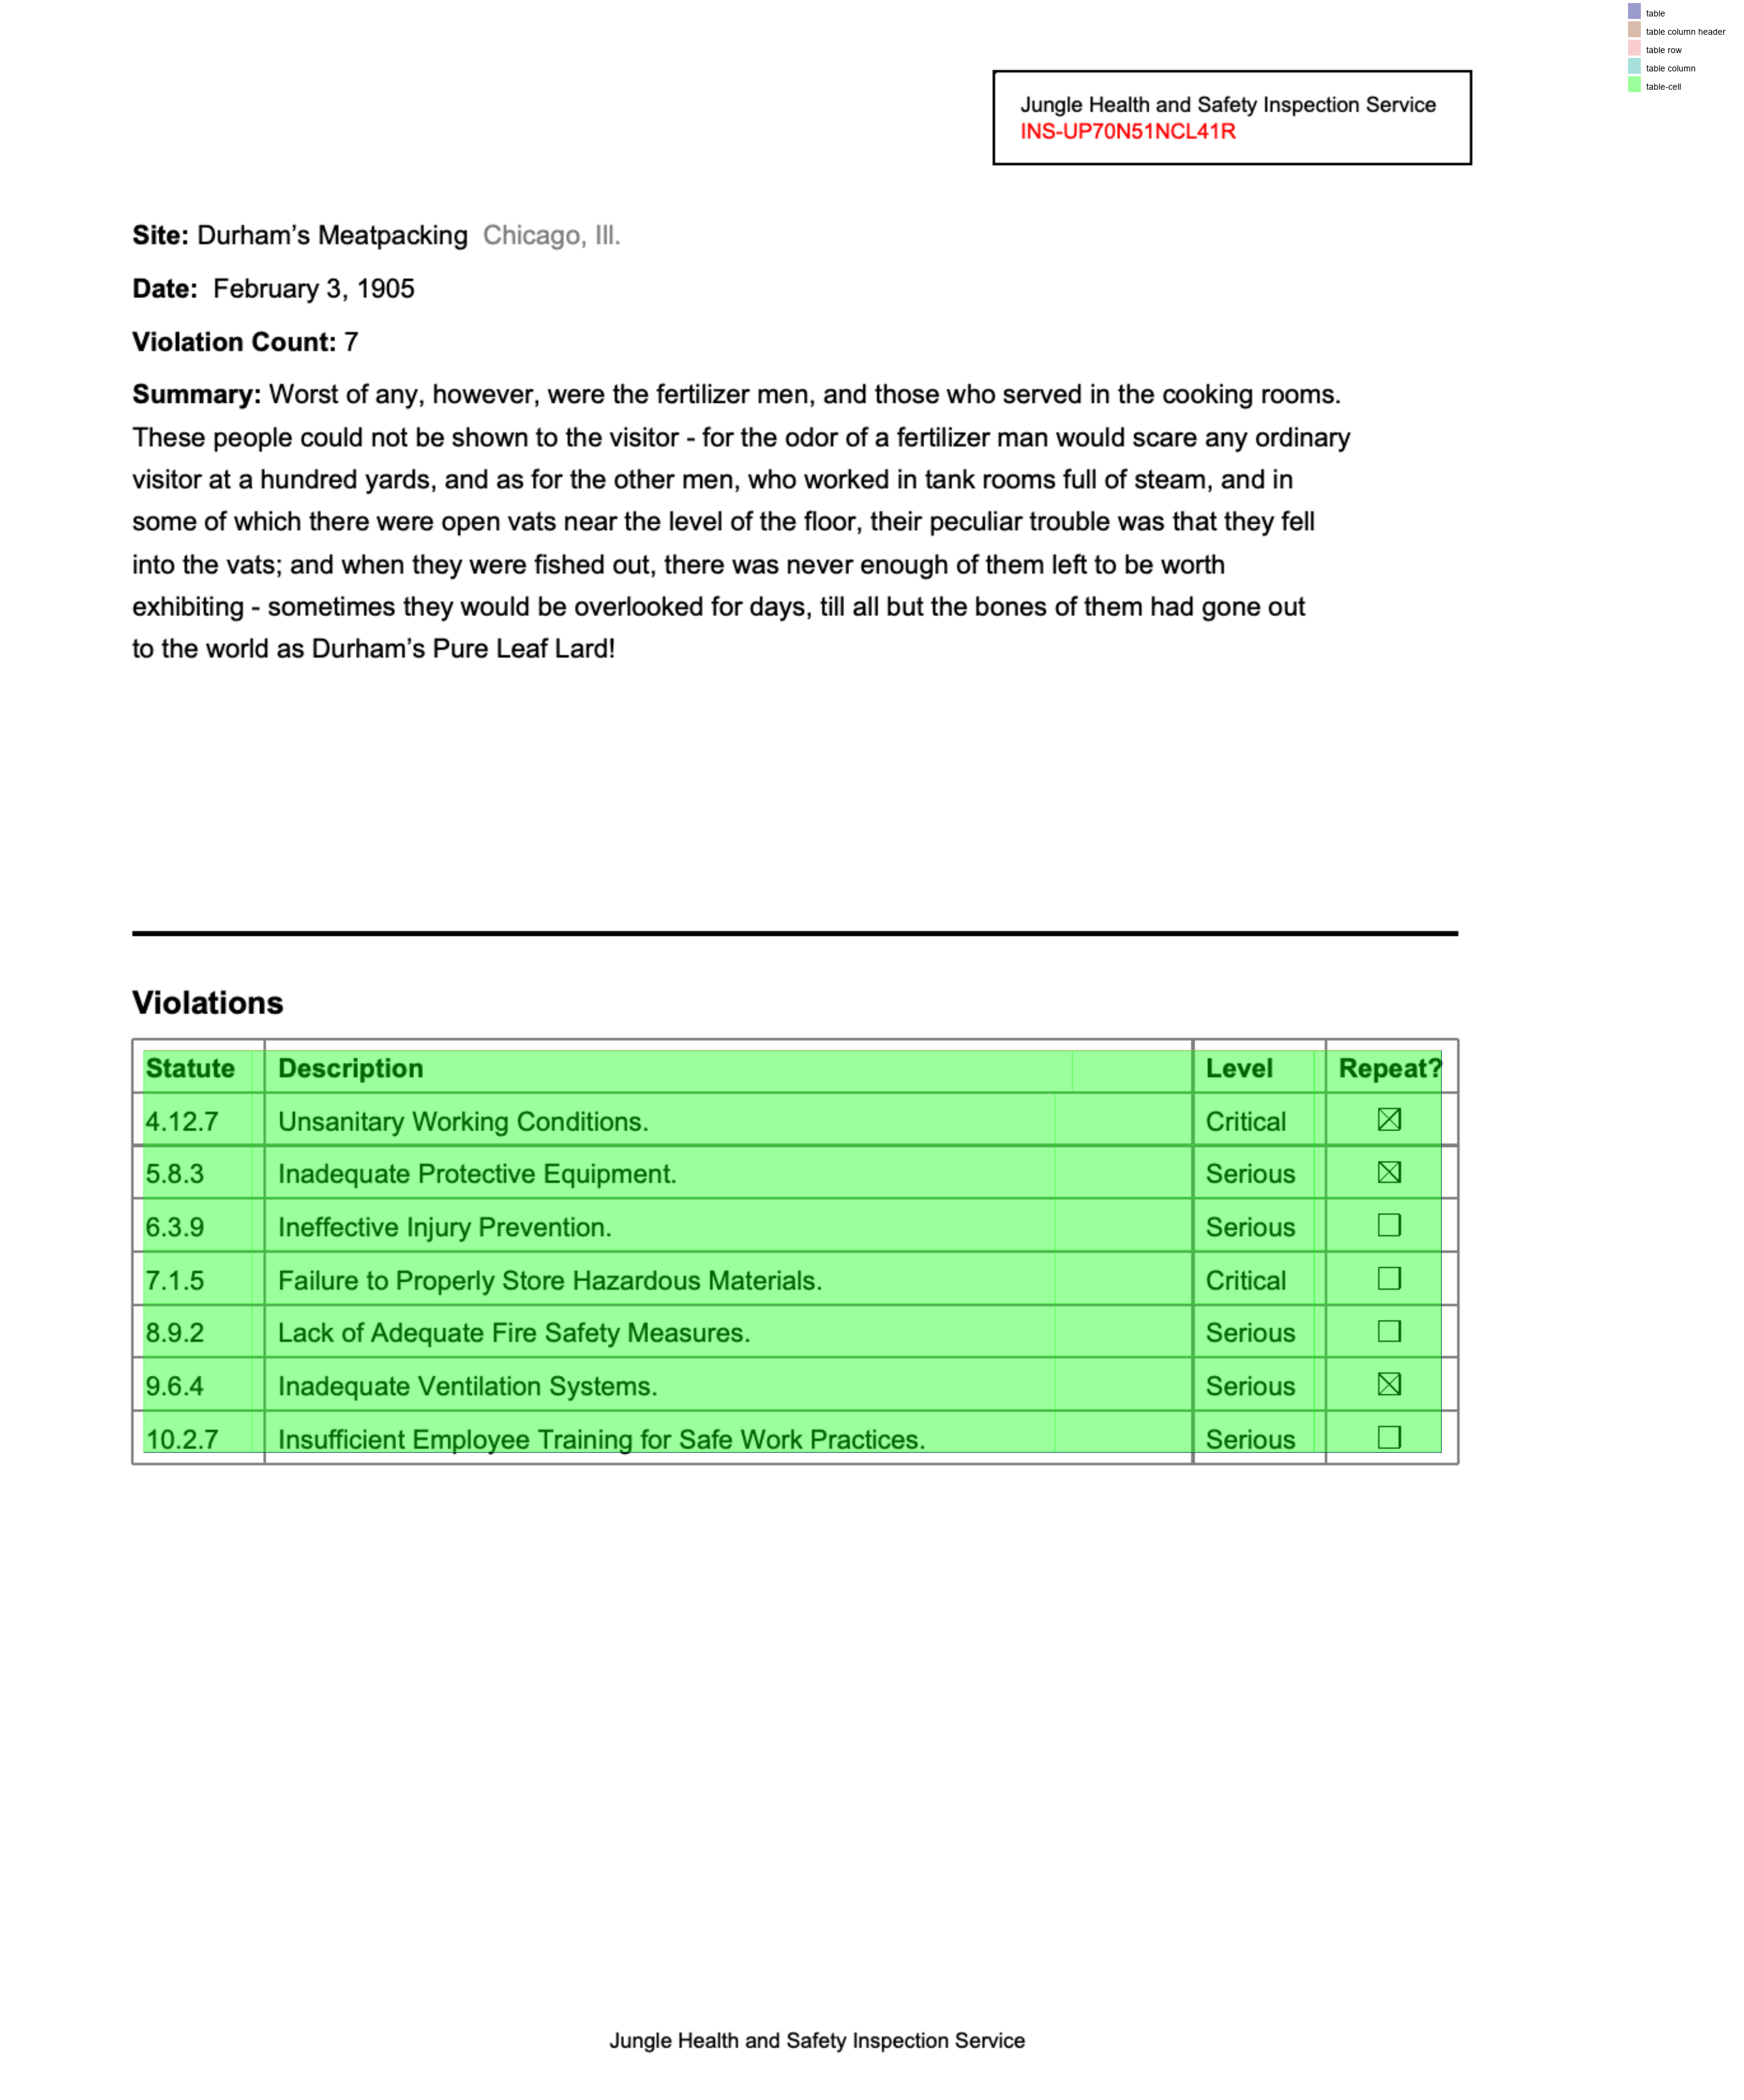

In [11]:
page.analyze_layout('tatr')
page.find_all('region').show(group_by='type')

There's just *so much stuff* that TATR is finding that it's all overlapping.

For example, we can just look at one piece at a time.

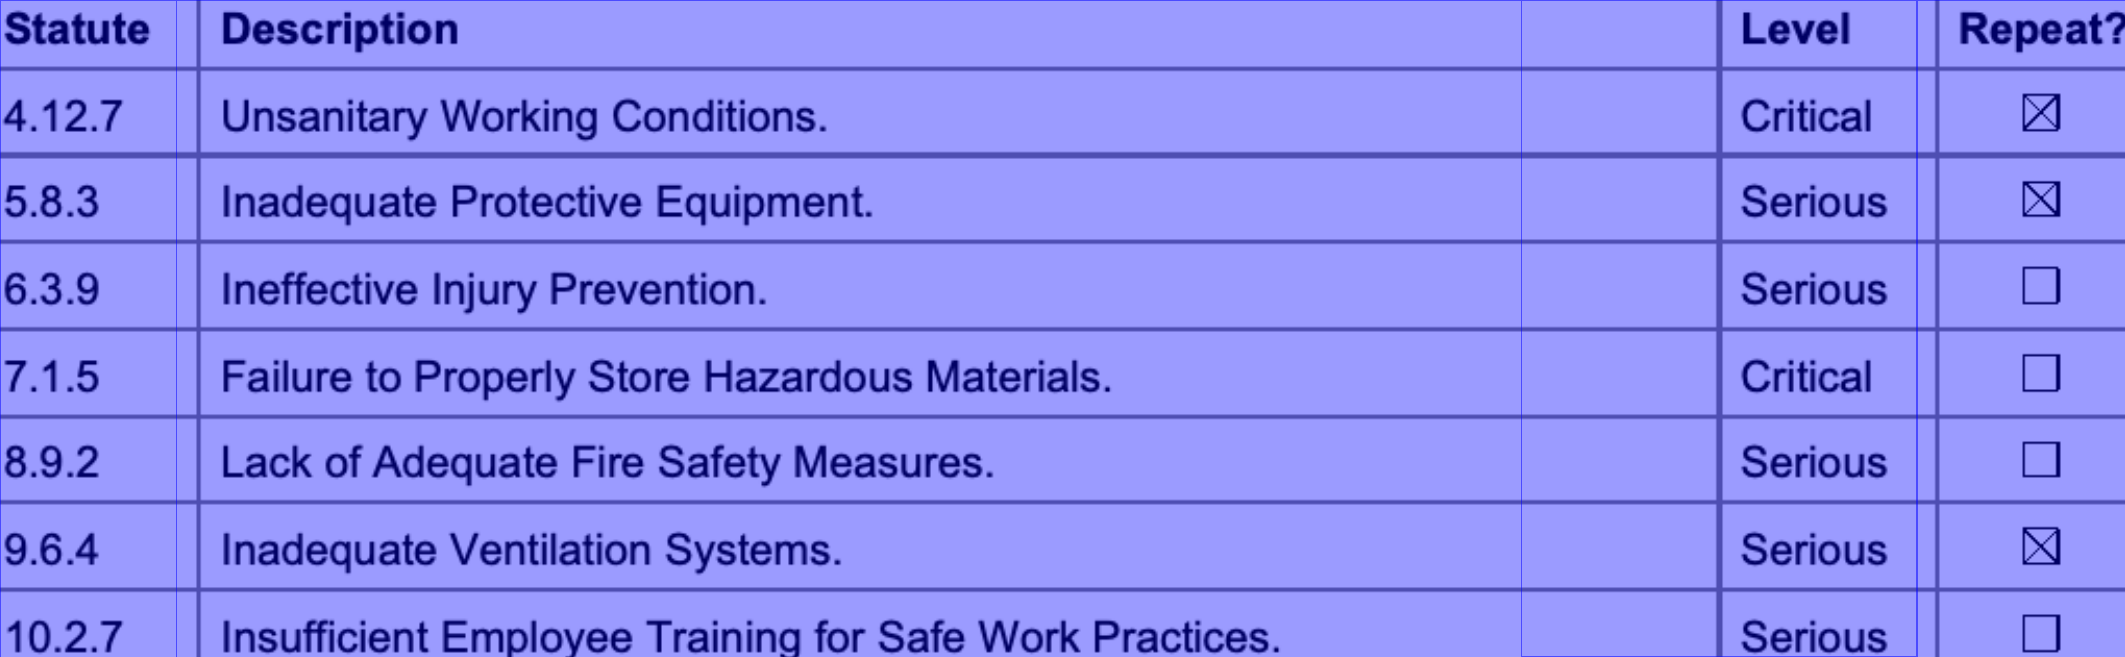

In [12]:
# table-cell
# table-row
# table-column
page.find_all('region[type=table-column]').show(crop=True)

In [13]:
# Grab all of the columns
cols = page.find_all('region[type=table-column]')

# Take one of the columns and apply OCR to it
cols[2].apply_ocr()
text = cols[2].extract_text()
print(text)

Level
Critical
Serious
Serious
Critical
Serious
Serious
Serious


In [14]:
len(cols[2].find_all('text[source=ocr]'))

8

In [15]:
page.find('table').show()

In [16]:
data = page.find('table').extract_table()
data

TableResult(rows=9…)

## Why YOLO?

I think YOLO is pretty good for isolating a part of a page that has a table, then using Guides to break it down.

In [17]:
page.analyze_layout()
page.find_all('region').show(group_by="type")


image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpm8hk82v_/temp_layout_image.png: 1024x800 2 titles, 3 plain texts, 2 abandons, 1 table, 731.2ms
Speed: 3.6ms preprocess, 731.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 800)


In [18]:
table_area = page.find("region[type=table]")
table_area.apply_ocr()

<Region type='table' source='detected' bbox=(99.85887908935547, 815.1997680664062, 1146.6968994140625, 1153.8369140625)>

In [19]:
text = table_area.extract_text()
print(text)

Statute Description Level Repeat?
4.12.7 Unsanitary Working Conditions. Critical
5.8.3 Inadequate Protective Equipment: Serious
6.3.9 Ineffective Injury Prevention  Serious
7.1.5 Failure to Properly Store Hazardous Materials Critical
8.9.2 Lack of Adequate Fire Safety Measures. Serious
9.6.4 Inadequate Ventilation Systems. Serious
10.2.7 Insufficient Employee Training for Safe Work Practices_ Serious


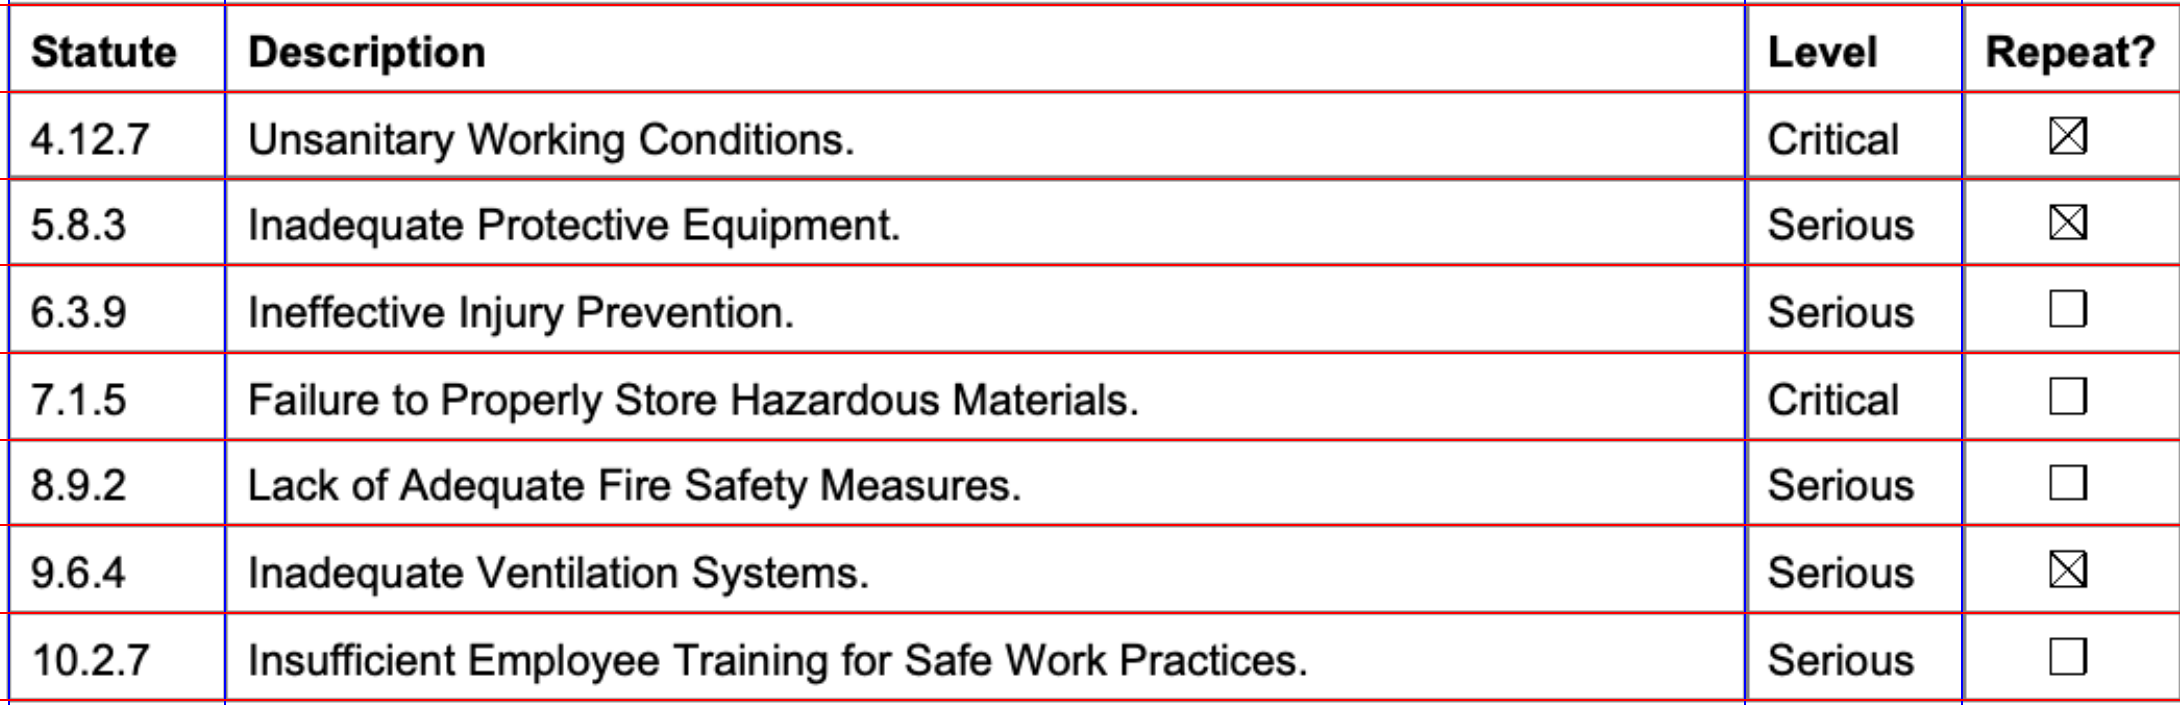

In [21]:
from natural_pdf.analyzers import Guides

guides = Guides(table_area)
guides.vertical.from_lines(threshold=0.6)
guides.horizontal.from_lines(threshold=0.6)
guides.show()